In [ ]:
# Install conda
!pip install -q condacolab
import condacolab
condacolab.install()
# Install astra-toolbox
!conda install -c astra-toolbox astra-toolbox
# Install odl
!pip3 install https://github.com/odlgroup/odl/archive/master.zip

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...
Channels:
 - astra-toolbox
 - conda-forge
Platform: linux-64
Solving environment: / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - astra-toolbox


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    astra-toolbox-2.1.3        |  py310hb150abf_0         539 KB  astra-toolbox
    ca-certificates-2024.2.2   |       hbcca054_0         152 KB  conda-forge
    certifi-2024.2.2           |     pyhd8ed1ab_0         157 KB  con

In [ ]:
import odl
import astra
astra.test()

ASTRA Toolbox v2.1.3
Getting GPU info... GPU #0: Tesla T4, with 15102MB, CUDA compute capability 7.5
Testing basic CPU 2D functionality... Ok
Testing basic CUDA 2D functionality... Ok
Testing basic CUDA 3D functionality... Ok


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import os
import pickle
import random
import numpy as np
import gzip

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


class CT_Dataset(Dataset):
    def __init__(self, sinograms, ground_truths,fbp_imgs):
        self.sinograms = sinograms
        self.ground_truths = ground_truths
        self.fbp_imgs = fbp_imgs

    def __len__(self):
        return len(self.sinograms)

    def __getitem__(self, index):
        sinogram = self.sinograms[index]
        ground_truth = self.ground_truths[index]
        fbp_imgs = self.fbp_imgs[index]
        return sinogram, ground_truth, fbp_imgs

Device: cuda


In [ ]:
img_size, space_range = 512, 128 #space discretization
num_angles, det_shape = 90, 180 #projection parameters
noise_std_dev = 5.0

space = odl.uniform_discr([-space_range, -space_range], [space_range, space_range],(512,512), dtype='float32', weighting=1.0)
geometry = odl.tomo.geometry.parallel.parallel_beam_geometry(space, num_angles=num_angles, det_shape=det_shape)
fwd_op_odl = odl.tomo.RayTransform(space, geometry)
opnorm = 1
#opnorm = odl.power_method_opnorm(fwd_op_odl)
rt = (1 / opnorm) * fwd_op_odl
fbp_op_odl = odl.tomo.fbp_op(fwd_op_odl,filter_type='Ram-Lak', frequency_scaling=0.6)

import odl.contrib.torch as odl_torch
A = odl_torch.OperatorModule(rt).to(device)
adjA = odl_torch.OperatorModule(rt.adjoint).to(device)
fbp = odl_torch.OperatorModule(fbp_op_odl).to(device)

In [ ]:
# import shutil
# file_path = "/content/drive/MyDrive/mnist_new"
# shutil.rmtree(file_path)

In [ ]:
from multiprocessing import Pool

folder_path = "/content/drive/MyDrive/MayoDataset/mayo_data"
file_list = [f for f in os.listdir(folder_path) if f.endswith('.npy')]

In [ ]:
def load_data(file_name):
    file_path = os.path.join(folder_path, file_name)
    data = np.load(file_path)
    return data

num_processes = os.cpu_count()
data_list = []
with Pool(processes=num_processes) as pool:
    for data in pool.imap_unordered(load_data, file_list):
        data_list.append(data)

In [ ]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

tensor_list = [transform(img) for img in data_list]
batch_size = 32  # Adjust as needed
dataloader = DataLoader(tensor_list, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sinograms = torch.empty(0, dtype=torch.float32, device=device)
ground_truths = torch.empty(0, dtype=torch.float32, device=device)
fbp_imgs = torch.empty(0, dtype=torch.float32, device=device)

with torch.no_grad():
    for images in dataloader:
        images = images.to(device)
        sinograms_batch = A(images)
        sinogram_noisy_batch = sinograms_batch
        fbp_img_batch = fbp(sinogram_noisy_batch)

        sinograms = torch.cat((sinograms, sinogram_noisy_batch), dim=0)
        ground_truths = torch.cat((ground_truths, images), dim=0)
        fbp_imgs = torch.cat((fbp_imgs, fbp_img_batch), dim=0)

In [ ]:
BATCH_SIZE = 1

In [ ]:
train_size = int(0.8*len(sinograms))
loaded_dataset = CT_Dataset(sinograms[:train_size], ground_truths[:train_size],fbp_imgs[:train_size])
train_dataloader = DataLoader(loaded_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CT_Dataset(sinograms[train_size:], ground_truths[train_size:],fbp_imgs[train_size:])
test_dataloader = DataLoader(loaded_dataset, batch_size=BATCH_SIZE, shuffle=True)

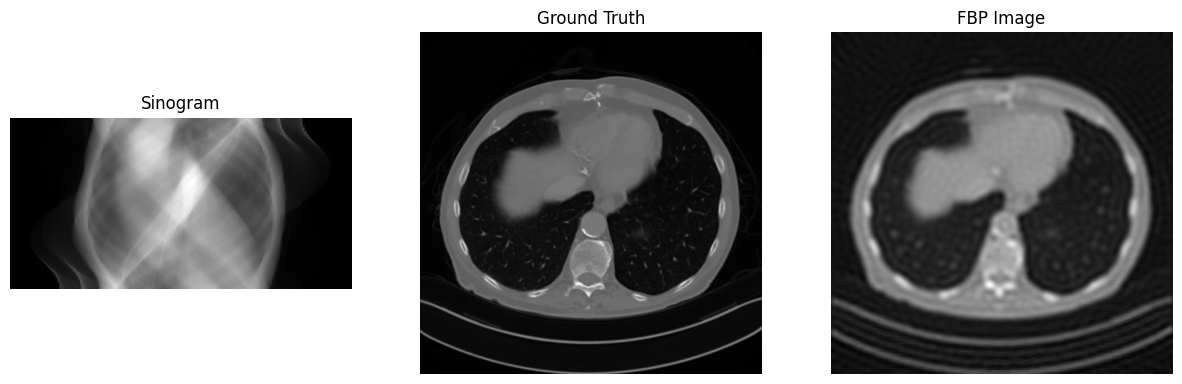

In [ ]:
import matplotlib.pyplot as plt
i = 0
for batch in train_dataloader:

    sinograms, ground_truths, fbp_imgs = batch

    # Visualize the first 8 sinograms, ground truth, and FBP images in the batch
    num_samples = min(8, sinograms.size(0))  # Limit to 8 samples for visualization
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 15))


    # Plot sinogram
    axes[0].imshow(sinograms[i].cpu().squeeze(), cmap='gray')
    axes[0].set_title('Sinogram')

    # Plot ground truth image
    axes[1].imshow(ground_truths[i].cpu().squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth')

    # Plot FBP image
    axes[2].imshow(fbp_imgs[i].cpu().squeeze(), cmap='gray')
    axes[2].set_title('FBP Image')

    # Remove axis ticks
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')

    plt.show()
    break

In [ ]:
# for batch in train_dataloader:
#     sinograms, ground_truths, fbp_imgs= batch
#     print(ground_truths.shape)
#     sin = sinograms[0].squeeze().cpu().numpy()
#     gt = ground_truths[0].squeeze().cpu().numpy()
#     fb = fbp_imgs[0].squeeze().cpu().numpy()
#     print(sin.shape)
#     print(gt.shape)
#     print(fb.shape)
#     break

torch.Size([4, 1, 512, 512])
(200, 400)
(512, 512)
(512, 512)


In [ ]:
import torch
import torch.nn as nn

class dual_net(nn.Module):
    def __init__(self, n_in_channels=3, n_out_channels = 1, n_filters=32, kernel_size=5):
        super(dual_net, self).__init__()
        self.pad = (kernel_size-1)//2
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)

        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)


    def forward(self, h, y, z):
        dh = torch.cat((h, y, z), dim=1)
        dh = self.act1(self.conv1(dh))
        dh = self.act2(self.conv2(dh))
        dh = self.conv3(dh)
        return h + dh

class primal_net(nn.Module):
    def __init__(self, n_in_channels=2, n_out_channels = 1, n_filters=32, kernel_size=5):
        super(primal_net, self).__init__()
        self.pad = (kernel_size-1)//2
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)

        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)

    def forward(self, x, u):
        dx = torch.cat((x, u), dim=1)
        dx = self.act1(self.conv1(dx))
        dx = self.act2(self.conv2(dx))
        dx = self.conv3(dx)
        return x + dx

class LPD(nn.Module):
    def __init__(self, fwd_op, adjoint_op, niter=12, sigma=0.01, tau=0.01):
        super(LPD, self).__init__()

        self.fwd_op = fwd_op
        self.adjoint_op = adjoint_op
        self.niter = niter
        self.sigma = nn.Parameter(sigma * torch.ones(self.niter).to(device))
        self.tau = nn.Parameter(tau * torch.ones(self.niter).to(device))
        self.primal_net = nn.ModuleList([primal_net().to(device) for i in range(self.niter)])
        self.dual_net = nn.ModuleList([dual_net().to(device) for i in range(self.niter)])

    def forward(self, y, x_init):
        x = x_init
        h = torch.zeros_like(y)
        for iteration in range(self.niter):
            h = self.dual_net[iteration](h, y, self.sigma[iteration] * self.fwd_op(x))
            x = self.primal_net[iteration](x, self.tau[iteration] * self.adjoint_op(h))
        return x

net = LPD(fwd_op = A,adjoint_op=adjA).to(device)

In [ ]:
import torch.optim as optim

start_epoch=0
end_epoch=15

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr = 5e-5, betas=(0.5, 0.99))

In [ ]:
your_google_drive_path = '/content/drive/MyDrive/btp_models/'
#If you are resuming your model, Uncomment following lines

# checkpoint = torch.load(your_google_drive_path+'checkpoint_CTLPD.pth')
# start_epoch = checkpoint['epoch']+1
# net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
def validator(testloader, net):
    net.eval()
    total_loss = 0.0
    with torch.no_grad():
        for measurements, ground_truths, fbp_imgs in testloader:
            measurements = measurements.to(device)
            ground_truths = ground_truths.to(device)
            x_fbp = fbp_imgs.to(device)
            outputs = net(y = measurements, x_init= x_fbp)
            loss = criterion(outputs, ground_truths)
            total_loss += loss.item()

    avg_loss = total_loss / len(testloader)
    return avg_loss

In [ ]:
import time
best_loss = float('inf')
for epoch in range(start_epoch, end_epoch):
    start_time = time.time()
    for i, (measurements, ground_truths,fbp_imgs) in enumerate(train_dataloader, 0):
        measurements = measurements.to(device)
        ground_truths = ground_truths.to(device)
        x_fbp = fbp_imgs.to(device)

        optimizer.zero_grad()
        outputs = net(y = measurements, x_init = x_fbp)
        loss = criterion(outputs, ground_truths)
        loss.backward()
        optimizer.step()

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f"Epoch: {epoch}, Loss: {loss}, Time: {epoch_time} seconds")

    # Validate the model and save if it's the best model
    current_test_loss = validator(test_dataloader, net)
    if current_test_loss < best_loss:
      best_loss = current_test_loss
      torch.save(
          {'epoch':epoch,
          'model_state_dict': net.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          },
          your_google_drive_path+'best_model_CTLPD.pth')

    torch.save(
        {'epoch':epoch,
         'model_state_dict': net.state_dict(),
         'optimizer_state_dict': optimizer.state_dict()
         },
         your_google_drive_path+'checkpoint_CTLPD.pth')

print('Finished Training')


Epoch: 0, Loss: 4116.99169921875, Time: 1016.586345911026 seconds
Epoch: 1, Loss: 2342.73486328125, Time: 1023.596741437912 seconds
Epoch: 2, Loss: 1616.320068359375, Time: 1023.5276737213135 seconds
Epoch: 3, Loss: 1288.754150390625, Time: 1019.8652174472809 seconds
Epoch: 4, Loss: 1350.760009765625, Time: 1018.7377767562866 seconds
Epoch: 5, Loss: 1048.1234130859375, Time: 1018.312751531601 seconds
Epoch: 6, Loss: 1008.8395385742188, Time: 1021.5798153877258 seconds
Epoch: 7, Loss: 12606.658203125, Time: 1018.7344257831573 seconds
Epoch: 8, Loss: 1188.407958984375, Time: 1016.9442937374115 seconds


In [ ]:
# Load the model
model_path = '/content/drive/MyDrive/btp_models/checkpoint_CTLPD.pth'
loaded_model = LPD(fwd_op = A,adjoint_op=adjA).to(device)
checkpoint = torch.load(model_path)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [ ]:
from math import log10, sqrt
def psnr(original, compressed):
    img1 = original.cpu().detach().numpy() if torch.is_tensor(original) else original
    img2 = compressed.cpu().detach().numpy() if torch.is_tensor(compressed) else compressed
    img1_norm = (img1-np.min(img1))/(np.max(img1)-np.min(img1))
    img2_norm = (img2-np.min(img2))/(np.max(img2)-np.min(img2))
    mse = np.mean((img1_norm - img2_norm) ** 2)
    if mse == 0:
        return 100
    max_pixel = np.max(img1_norm)
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

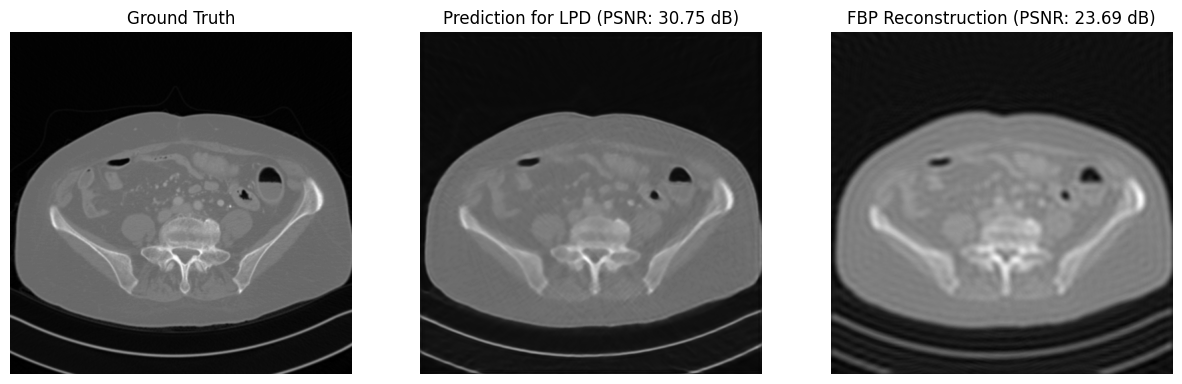

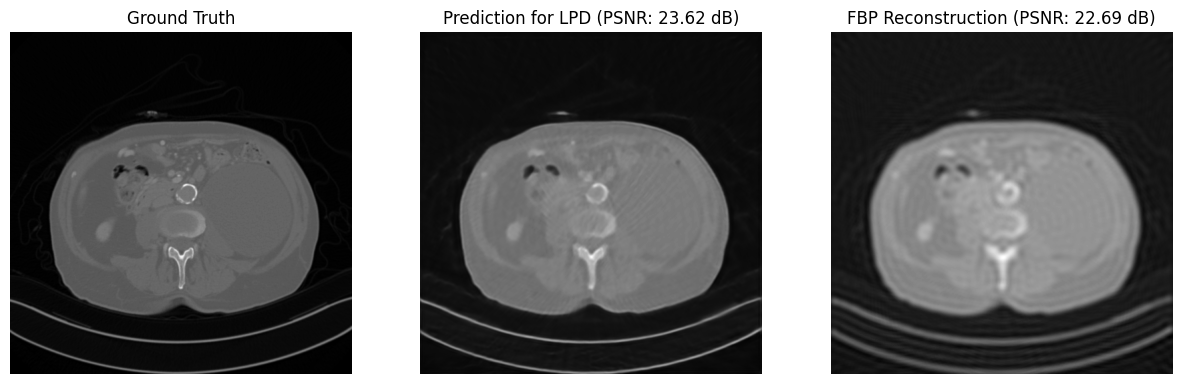

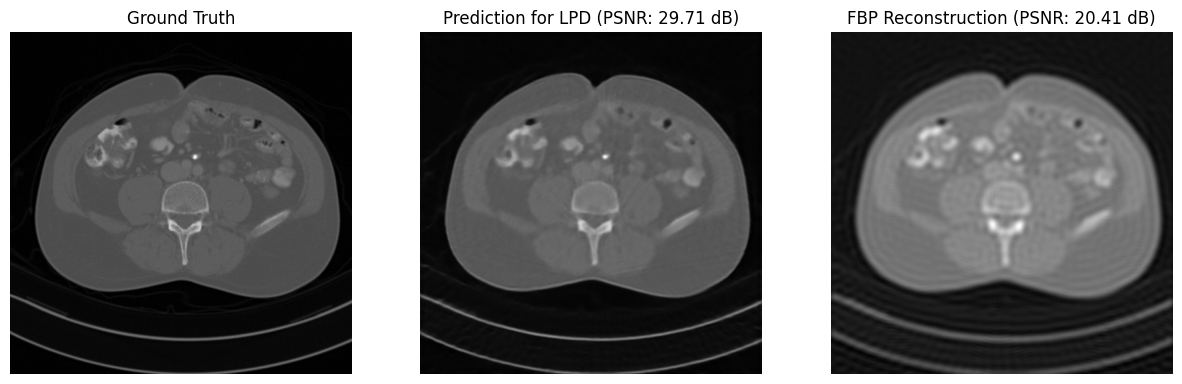

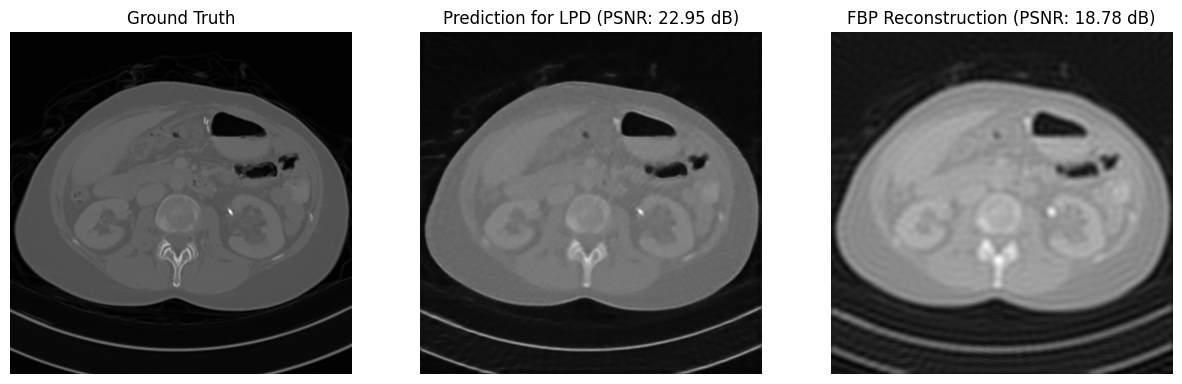

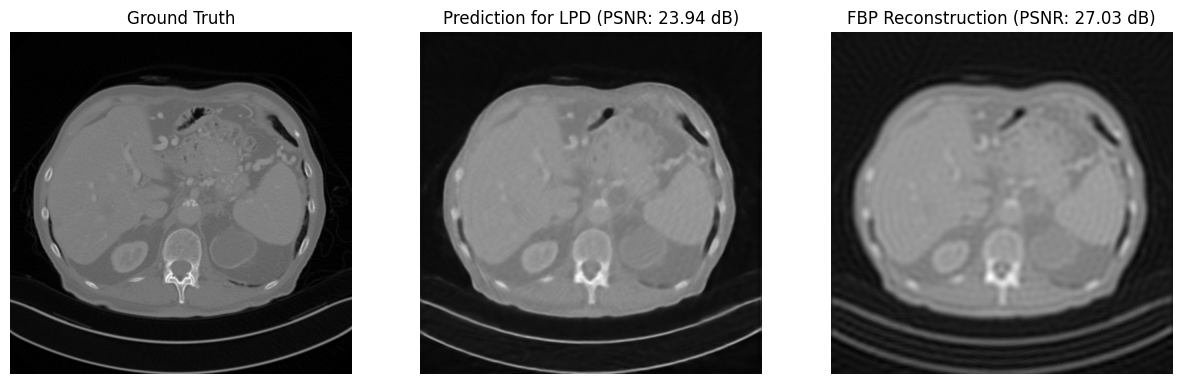

Average PSNR: 26.20 dB
Average PSNR for FBP: 22.52 dB


In [ ]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
loaded_model.eval()

# Number of samples to visualize and calculate PSNR
num_samples = 5

# Randomly select samples from the testing dataset
batch_indices = np.random.choice(len(test_dataloader), num_samples, replace=True)

psnr_values = []
psnr_fbp_values = []

with torch.no_grad():  # No need to calculate gradients during testing
    for idx in batch_indices:
        # Get the batch from the test dataloader
        batch_measurements, batch_ground_truths , batch_fbp_imgs = test_dataloader.dataset[idx]

        # Move the batch to the appropriate device
        batch_measurements = batch_measurements.unsqueeze(1).to(device)
        batch_ground_truths = batch_ground_truths.unsqueeze(1).to(device)
        batch_fbp_imgs = batch_fbp_imgs.unsqueeze(1).to(device)

        # Forward pass
        x_fbp_batch = batch_fbp_imgs.to(device)
        batch_outputs = loaded_model(y=batch_measurements,x_init= x_fbp_batch)

        # Calculate PSNR
        psnr_val = psnr(batch_ground_truths, batch_outputs)
        psnr_fbp = psnr(x_fbp_batch, batch_outputs)
        psnr_values.append(psnr_val)
        psnr_fbp_values.append(psnr_fbp)

        # Convert tensors to numpy arrays for visualization
        batch_ground_truths_np = batch_ground_truths.squeeze().cpu().numpy()
        batch_outputs_np = batch_outputs.squeeze().cpu().numpy()
        x_fbp_batch_np = x_fbp_batch.squeeze().cpu().numpy()

        # Plot ground truth, prediction, and x_fbp_test for the batch
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(batch_ground_truths_np, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(batch_outputs_np, cmap='gray')
        plt.title('Prediction for LPD (PSNR: {:.2f} dB)'.format(psnr_val))
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(x_fbp_batch_np, cmap='gray')
        plt.title('FBP Reconstruction (PSNR: {:.2f} dB)'.format(psnr_fbp))
        plt.axis('off')

        plt.show()

# Calculate average PSNR
average_psnr = np.mean(psnr_values)
average_psnr_fbp = np.mean(psnr_fbp_values)
print('Average PSNR: {:.2f} dB'.format(average_psnr))
print('Average PSNR for FBP: {:.2f} dB'.format(average_psnr_fbp))


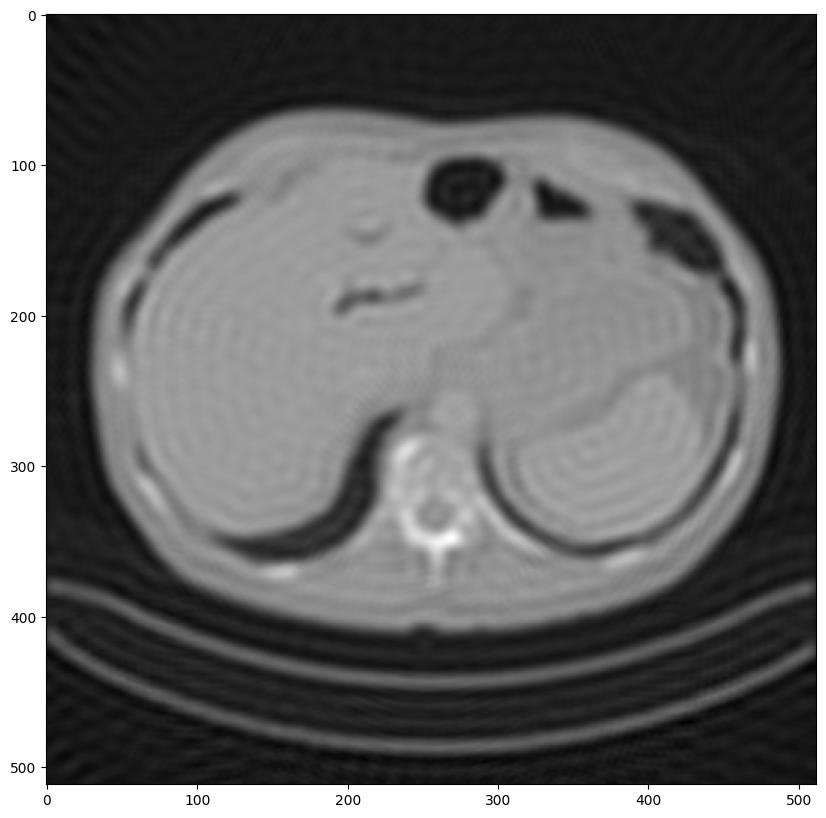

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(x_fbp_batch_np,cmap = 'gray')

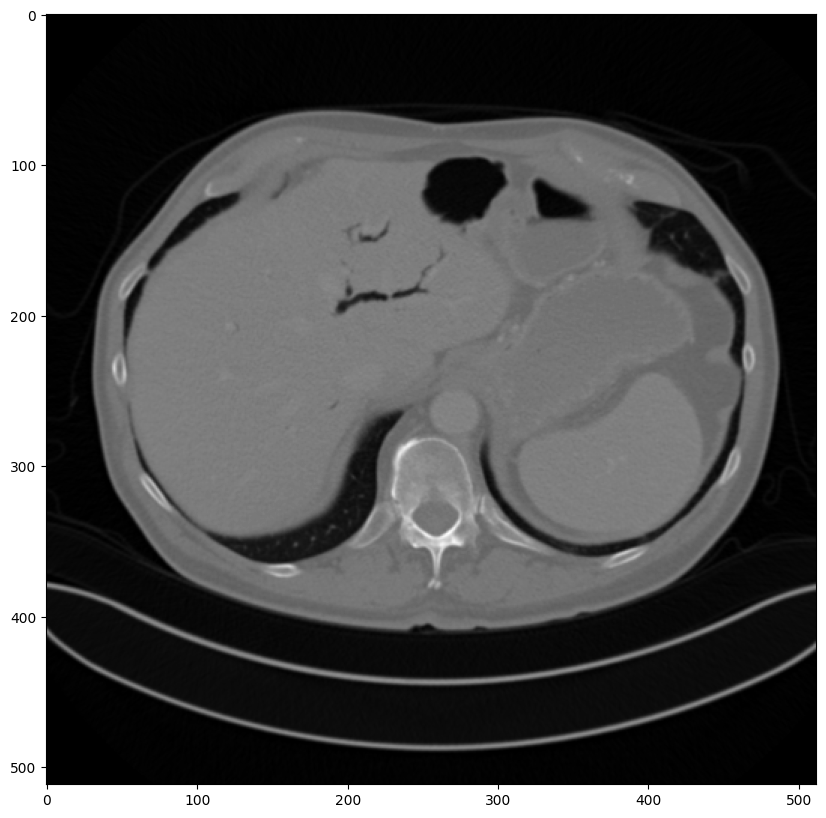

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(batch_ground_truths_np,cmap = 'gray')

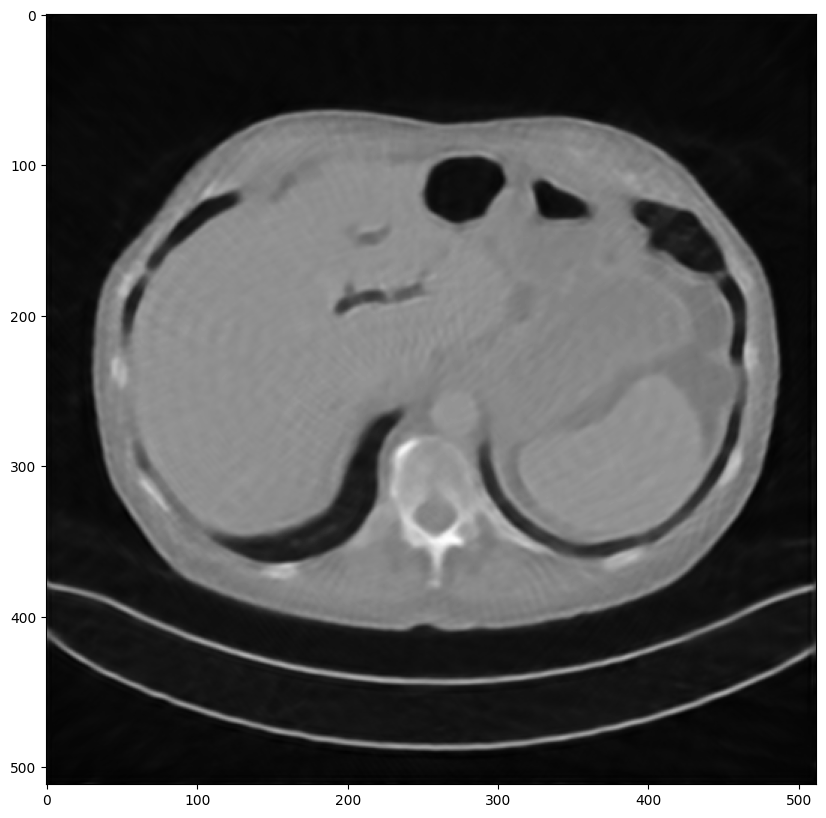

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(batch_outputs_np,cmap = 'gray')

In [ ]:
torch.cuda.empty_cache()